# Image Processing (Part 2) Fourier Domain

## What is a Function in the Time Domain?

- A time-domain function describes how a quantity changes with time or space.
- Examples we see daily:
  - Audio waveforms: $ f(t) $ = amplitude of sound at time $ t $.
  - Temperature readings: $ T(x) $ = temperature at position $ x $.
  - ECG signals: $ V(t) $ = voltage across time.
- These functions are plotted with respect to time/space.

**Mathematically:**  
$ f(t): \mathbb{R} \to \mathbb{R} $ — maps time to amplitude.

---

## What is the Frequency (Fourier) Domain?

- The frequency domain expresses a signal as a sum of sinusoids.
- Instead of analyzing *when* things happen, we analyze *what frequencies* are present.

**Example:**  
$ f(t) = \sin(2\pi \cdot 5t) $  
→ A 5 Hz sine wave has **one spike at 5 Hz** in frequency domain.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# === Signal + FFT plotting function ===
def plot_signal(freq1, add_second, freq2):
    fs = 1000          # Sampling rate
    T = 1.0            # Duration
    t = np.linspace(0, T, int(fs*T), endpoint=False)

    # --- Construct signal ---
    signal = np.sin(2 * np.pi * freq1 * t)
    if add_second:
        signal += 0.5 * np.sin(2 * np.pi * freq2 * t)

    # --- Compute FFT ---
    fft_vals = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(t), 1/fs)
    half = len(t) // 2
    fft_mag = np.abs(fft_vals) / len(t)
    fft_freqs = fft_freqs[:half]
    fft_mag = fft_mag[:half]

    # --- Plot ---
    plt.figure(figsize=(12, 4))

    # Time domain
    plt.subplot(1, 2, 1)
    plt.plot(t, signal, color='royalblue')
    title = f"Time Domain: {freq1} Hz"
    if add_second:
        title += f" + {freq2} Hz"
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Frequency domain
    plt.subplot(1, 2, 2)
    plt.stem(fft_freqs, fft_mag)
    plt.title("Frequency Domain: FFT Magnitude Spectrum")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# === Interactive Widgets ===
freq1_slider = widgets.IntSlider(value=30, min=1, max=200, step=1, description="Freq 1 (Hz)")
add_second_wave = widgets.Checkbox(value=False, description="Add Second Wave")
freq2_slider = widgets.IntSlider(value=80, min=1, max=200, step=1, description="Freq 2 (Hz)")

ui = widgets.VBox([freq1_slider, add_second_wave, freq2_slider])
out = widgets.interactive_output(
    plot_signal,
    {'freq1': freq1_slider, 'add_second': add_second_wave, 'freq2': freq2_slider}
)

display(ui, out)

Output()

## How good is the reconstruction?

When shifting from time domain to frequency domain and shifting back to time domain from freq domain, do we loose any information?

No, **if the Fourier Transform and its inverse are applied correctly**, we do **not lose any information** during the shift between time and frequency domains.

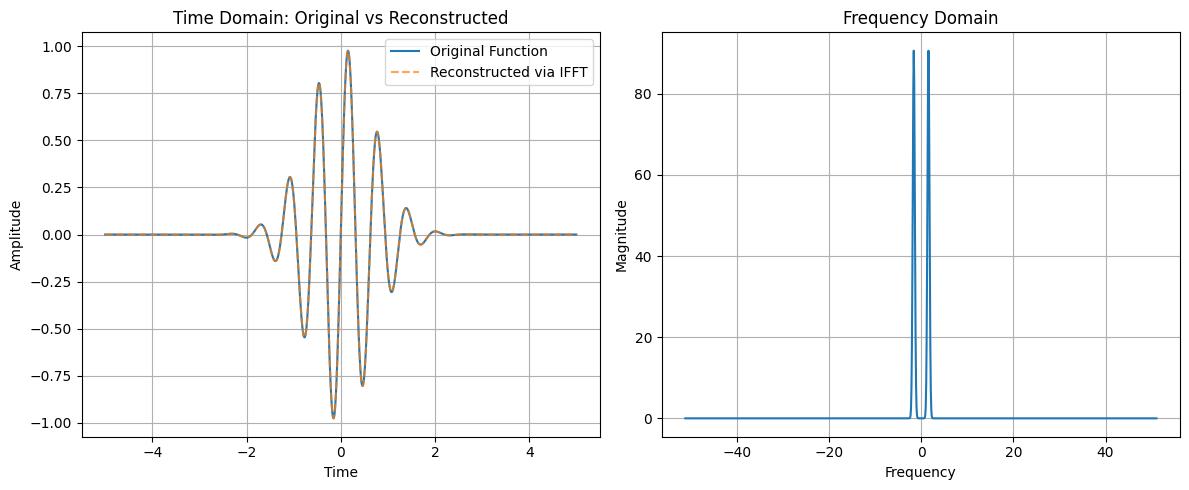

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Define any function: Gaussian pulse
t = np.linspace(-5, 5, 1024)
f = np.exp(-t**2) * np.sin(10 * t)  # Smooth but nontrivial

# Compute FFT and inverse FFT
F = np.fft.fft(f)
freq = np.fft.fftfreq(len(t), d=t[1] - t[0])
f_reconstructed = np.fft.ifft(F).real  # Imaginary part should be ~0

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t, f, label="Original Function")
plt.plot(t, f_reconstructed, '--', label="Reconstructed via IFFT", alpha=0.7)
plt.title("Time Domain: Original vs Reconstructed")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.fft.fftshift(freq), np.fft.fftshift(np.abs(F)), label="|FFT|")
plt.title("Frequency Domain")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.grid(True)

plt.tight_layout()
plt.show()

**Fourier Transform:**

$$
F(\omega) = \int_{-\infty}^{\infty} f(t) e^{-i \omega t} \, dt
$$

- $ F(\omega) $ tells us how much of frequency $ \omega $ exists in $ f(t) $.

---

## Moving Between Domains

- We can go from time to frequency using the **Fourier Transform**.
- The inverse gets us back to time domain.

$$
F(\omega) = \int_{-\infty}^{\infty} f(t) e^{-i \omega t} \, dt \quad \text{(Forward)}
$$
$$
f(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} F(\omega) e^{i \omega t} \, d\omega \quad \text{(Inverse)}
$$

**Why do this?**  
Some operations (like filtering, compression, pattern detection) are **easier in the frequency domain** because they become algebraic (e.g., multiplication instead of convolution), enabling more efficient computation and intuitive manipulation of signal characteristics.

---

## Interpreting Images as Functions

- An image can be modeled as a 2D function:

$$
I(x, y): \mathbb{R}^2 \to \mathbb{R}
$$

- $ x $ and $ y $ are spatial coordinates.
- $ I(x, y) $ gives pixel intensity at location $ (x, y) $.

**Examples:**
- Grayscale image: $ I(x, y) $ is scalar.
- Color image: $ I(x, y) $ is a vector (R, G, B).

Thus, **images are time-domain 2D signals**.

---

## Fourier Transform of Images

- The **2D Fourier Transform** of an image:

$$
F(u, v) = \iint I(x, y) \cdot e^{-2\pi i (ux + vy)} \, dx \, dy
$$

- Transforms image from spatial domain to frequency domain.

**Features extracted:**
- Low frequencies: global structures (smooth regions).
- High frequencies: edges, textures, details.


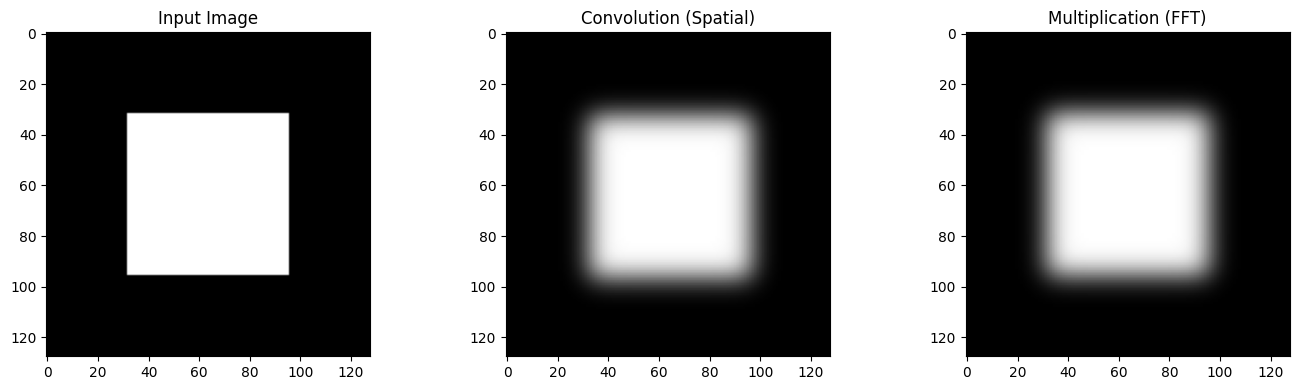

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from numpy.fft import fft2, ifft2, fftshift, ifftshift

# Step 1: Create base image
N = 128
image = np.zeros((N, N))
image[32:96, 32:96] = 1  # white square

# Step 2: Create Gaussian kernel centered
sigma = 5
kernel = np.zeros((N, N))
kernel[N//2, N//2] = 1
kernel = gaussian_filter(kernel, sigma=sigma)

# Step 3: Convolve in spatial domain
spatial_output = convolve2d(image, kernel, mode='same')

# Step 4: Proper FFT convolution
# Step 4.1: FFT of image and kernel
F_image = fft2(image)
F_kernel = fft2(ifftshift(kernel))  # Center the kernel

# Step 4.2: Multiply in frequency domain
F_output = F_image * F_kernel
freq_output = np.real(ifft2(F_output))

# Step 5: Show all
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(spatial_output, cmap='gray')
plt.title("Convolution (Spatial)")

plt.subplot(1, 3, 3)
plt.imshow(freq_output, cmap='gray')
plt.title("Multiplication (FFT)")

plt.tight_layout()
plt.show()

# Compare outputs
is_close = np.allclose(spatial_output, freq_output, atol=1e-6)
max_diff = np.max(np.abs(spatial_output - freq_output))

## What are the performance improvements?

### Time Complexity: Matrix Multiplication vs FFT

In image processing, when we apply a filter (or kernel) of size $ m \times m $ to an image of size $ n \times n $, we are essentially performing a 2D convolution. This can be implemented directly in the spatial (time) domain or efficiently in the frequency (Fourier) domain.

---

#### Time-Domain Convolution (Matrix Multiply)

In the time domain, for each of the $ n^2 $ pixels in the image, the filter slides over and computes a weighted sum using all $ m^2 $ filter elements.

Thus, the total number of operations is:

$$
\mathcal{O}(n^2 \cdot m^2)
$$

This becomes expensive when either $ n $ or $ m $ is large — especially if the kernel is not tiny (e.g., Gaussian blur with $ m = 51 $).

---

#### Frequency-Domain Convolution (FFT)

Using the **Fast Fourier Transform (FFT)**, we convert both the image and kernel to the frequency domain, multiply them point-wise, and then apply the inverse FFT. The steps are:

1. **Zero-pad** both inputs to avoid wrap-around: typically pad to $ (n + m - 1) \times (n + m - 1) $
2. **Forward FFT** of both image and kernel:  
   
   $$
   \mathcal{O}(N^2 \log N) \quad \text{where } N = n + m - 1
   $$
   
3. **Pointwise multiplication**: $ \mathcal{O}(N^2) $
4. **Inverse FFT**: $ \mathcal{O}(N^2 \log N) $

Total complexity:

$$
\mathcal{O}(N^2 \log N) \approx \mathcal{O}(n^2 \log n)
$$

---

#### Comparison Summary

| Method              | Time Complexity             | Better When         |
|---------------------|------------------------------|----------------------|
| Time-domain (naive) | $ \mathcal{O}(n^2 m^2) $   | Small kernels        |
| Frequency-domain    | $ \mathcal{O}(n^2 \log n) $ | Large kernels / images |

Thus, **FFT-based convolution is asymptotically faster** for large images and kernels. In practice, libraries like NumPy and SciPy switch to FFT automatically when the kernel is large.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time
import ipywidgets as widgets
from IPython.display import display
from scipy.linalg import toeplitz

def run_direct_vs_fft_benchmark(max_n, step):
    ns = np.arange(1000, max_n + 1, step)
    times_direct = []
    times_fft = []

    kernel_size = 1000
    h = np.random.rand(kernel_size)

    for n in ns:
        x = np.random.rand(n)
        output_len = n + kernel_size - 1

        # === Direct Time-Domain using Toeplitz matrix multiplication ===
        start_td = time.time()

        first_col = np.concatenate([h, np.zeros(n - 1)])
        first_row = np.zeros(n)
        toeplitz_matrix = toeplitz(first_col, first_row)
        y_direct = toeplitz_matrix @ x

        end_td = time.time()
        times_direct.append(end_td - start_td)

        # === FFT-based Convolution ===
        start_fd = time.time()

        X = np.fft.fft(x, output_len)
        H = np.fft.fft(h, output_len)
        y_fft = np.fft.ifft(X * H).real

        end_fd = time.time()
        times_fft.append(end_fd - start_fd)

    # === Plot ===
    plt.figure(figsize=(10, 5))
    plt.plot(ns, times_direct, label='Matrix Multiply (Toeplitz)', marker='o')
    plt.plot(ns, times_fft, label='Fourier Domain (FFT)', marker='o')
    plt.xlabel("Signal Size (n)")
    plt.ylabel("Execution Time (seconds)")
    plt.title("Linear Filtering: Direct Matrix Multiply vs Fourier (FFT)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Interactive Sliders ===
max_n_slider = widgets.IntSlider(value=10000, min=2000, max=20000, step=1000, description='Max n')
step_slider = widgets.IntSlider(value=2000, min=500, max=5000, step=500, description='Step Size')

ui = widgets.VBox([max_n_slider, step_slider])
out = widgets.interactive_output(run_direct_vs_fft_benchmark, {
    'max_n': max_n_slider,
    'step': step_slider
})

display(ui, out)

Output()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
import ipywidgets as widgets
from IPython.display import display
from scipy.signal import fftconvolve

def run_convolution_benchmark_large_kernel(max_n, step):
    ns = np.arange(1000, max_n + 1, step)
    times_td = []
    times_fd = []

    kernel_size = 1000  # Large kernel to show FFT advantage

    for n in ns:
        x = np.random.rand(n)
        h = np.random.rand(kernel_size)

        # --- Time Domain ---
        start_td = time.time()
        np.convolve(x, h, mode='full')
        end_td = time.time()
        times_td.append(end_td - start_td)

        # --- Fourier Domain ---
        start_fd = time.time()
        fftconvolve(x, h, mode='full')
        end_fd = time.time()
        times_fd.append(end_fd - start_fd)

    # --- Plot ---
    plt.figure(figsize=(10, 5))
    plt.plot(ns, times_td, label='Time Domain (np.convolve)', marker='o')
    plt.plot(ns, times_fd, label='Fourier Domain (fftconvolve)', marker='o')
    plt.xlabel("Signal Size (n)")
    plt.ylabel("Execution Time (seconds)")
    plt.title("Convolution Time with Large Kernel (size = 1000)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Interactive Widgets ===
max_n_slider = widgets.IntSlider(value=10000, min=2000, max=30000, step=1000, description='Max n')
step_slider = widgets.IntSlider(value=2000, min=500, max=5000, step=500, description='Step Size')

ui = widgets.VBox([max_n_slider, step_slider])
out = widgets.interactive_output(run_convolution_benchmark_large_kernel, {
    'max_n': max_n_slider,
    'step': step_slider
})

display(ui, out)

Output()

In [14]:
# ---- FUNCTIONS CELL ----

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift
from numpy.lib.stride_tricks import as_strided

def pad_kernel(kernel, shape):
    """
    Zero-pad the kernel to match the image size and center it.
    """
    kh, kw = kernel.shape
    H, W = shape
    padded = np.zeros((H, W), dtype=np.float32)
    padded[:kh, :kw] = kernel
    padded = np.roll(padded, -kh // 2, axis=0)
    padded = np.roll(padded, -kw // 2, axis=1)
    return padded

def convolve2d_spatial(image, kernel):
    """
    Slow spatial domain convolution using explicit loops.
    """
    h, w = image.shape
    k, _ = kernel.shape
    pad = k // 2
    padded = np.pad(image, pad_width=pad, mode='edge')
    output = np.zeros_like(image)
    for i in range(h):
        for j in range(w):
            region = padded[i:i+k, j:j+k]
            output[i, j] = np.sum(region * kernel)
    return output

def plot_images_grid(images, titles=None, images_per_row=2, figsize=(12, 6), cmap = None):
    num_images = len(images)
    num_rows = (num_images + images_per_row - 1) // images_per_row
 
    plt.figure(figsize=figsize)
    
    for idx, img in enumerate(images):
        plt.subplot(num_rows, images_per_row, idx + 1)
        plt.imshow(img, cmap=cmap)
        if titles and idx < len(titles):
            plt.title(titles[idx])
        img_shape = f"{img.shape[0]}x{img.shape[1]}"
        plt.xlabel(f"Shape: {img_shape}", fontsize=9)
        plt.axis('off')
 
    plt.tight_layout()
    plt.show()


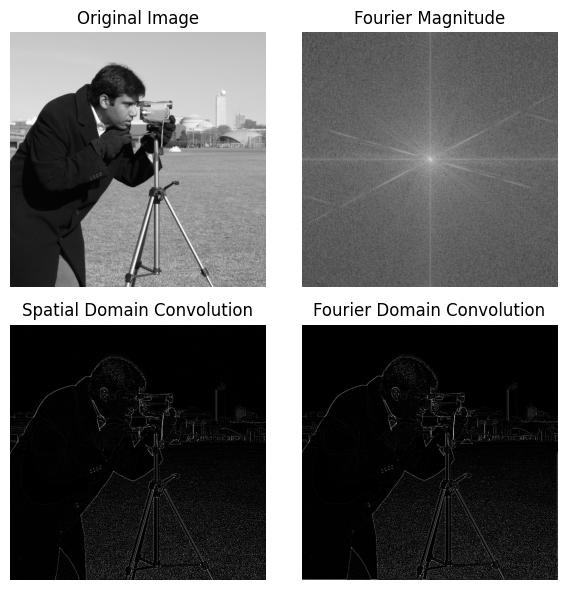

In [15]:
# ---- EXECUTION CELL ----

from skimage.data import camera

# Load grayscale image
img = camera().astype(np.float32)

# Define a kernel (Laplacian for edge detection)
kernel = np.array([
    [0, -1, 0],
    [-1, 4, -1],
    [0, -1, 0]
], dtype=np.float32)

# Step 1: Fourier Transform of Image
F_img = fft2(img)
magnitude_spectrum = np.log(1 + np.abs(fftshift(F_img)))  # Log for better visibility

# Step 2: Spatial Domain Convolution
out_spatial = convolve2d_spatial(img, kernel)
out_spatial = np.clip(out_spatial, 0, 255)

# Step 3: Fourier Domain Convolution
kernel_padded = pad_kernel(kernel, img.shape)
F_kernel = fft2(kernel_padded)
F_out = F_img * F_kernel
out_fourier = np.real(ifft2(F_out))
out_fourier = np.clip(out_fourier, 0, 255)

# Step 4: Plot all four images
plot_images_grid(
    images=[
        img.astype(np.uint8),
        magnitude_spectrum,
        out_spatial.astype(np.uint8),
        out_fourier.astype(np.uint8)
    ],
    titles=[
        "Original Image",
        "Fourier Magnitude",
        "Spatial Domain Convolution",
        "Fourier Domain Convolution"
    ],
    images_per_row=2,
    figsize=(6, 6),
    cmap="gray"
)

In [16]:
import numpy as np
import time
from scipy.signal import convolve2d, fftconvolve

# Create a sample image and kernel
image_size = 1024     # Image: 1024 x 1024
kernel_size = 51      # Kernel: 51 x 51

image = np.random.rand(image_size, image_size)
kernel = np.random.rand(kernel_size, kernel_size)

# Time convolve2d
start_time = time.time()
output_convolve2d = convolve2d(image, kernel, mode='same')
time_convolve2d = time.time() - start_time

# Time fftconvolve
start_time = time.time()
output_fftconvolve = fftconvolve(image, kernel, mode='same')
time_fftconvolve = time.time() - start_time

# Time gain
time_gain = time_convolve2d / time_fftconvolve

# Output
print(f"convolve2d time:   {time_convolve2d:.5f} seconds")
print(f"fftconvolve time:  {time_fftconvolve:.5f} seconds")
print(f"Time gain (conv2d / fft): {time_gain:.2f}x")
print(f"Outputs match? {np.allclose(output_convolve2d, output_fftconvolve, atol=1e-5)}")

convolve2d time:   4.23625 seconds
fftconvolve time:  0.02170 seconds
Time gain (conv2d / fft): 195.21x
Outputs match? True
